# Regularized logistic regression
## Problem statement
We want to be sure to pass a quality check to see if microchips perform OK.
During QA (Quality Assurance), each microchip goes through various tests to ensure it is functioning correctly. 
We have the data for 2 tests and have identified if the chips were OK in those tests or not.
0 means the chip has been rejected and 1 means accepted.
We will use regularized logistic regression using the data to predict the quality of our batches. 

## Loading  libraries.

In [15]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Import the necessary packages
# This time we are going to use an optimizer out of the scipy.optimize package. Abreviate to opt.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import itertools as it

## We read the data

Put all data in X, except for the last column. 

The last column contains the label info (0 or 1, to indicate that a specific chip is not OK or OK, respectively).

I'll refer to $x_1$ and $x_2$ for the first and second column of X.

In [16]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Read the data from the file "ex2data2.txt" (available on Canvas) and display
# the top 5 rows of this data.
# Display also the top rows of this file
data = pd.read_csv('Data/ex2data2.txt', header=None)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
data.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


## Visualizing the data : always good 

Let's first identify the chips that pass our quality check and those chips that don't pass the check.

For this create a mask that verifies if the output is 1 (so a test for our output variable y, equaling 1) on the 2 features in our matrix X?

We'll use this mask as a filter on both the $x_1$ and $x_2$ data.

In [17]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Create the mask variable:
mask = y == 1

Let's apply this mask to both our variables $x_1$ and $x_2$ (within X).
Let's create a scatter plot of the data ($x_1$ vs $x_2$).
We'll draw both scatterplots -  those that passed and those that didn't - in the same drawing.

For the $x_1$ label (xlabel) we'll give it the name 'Microchip Test1'.
For the $x_2$ label (ylabel) we'll give it the name 'Microchip Test2'.

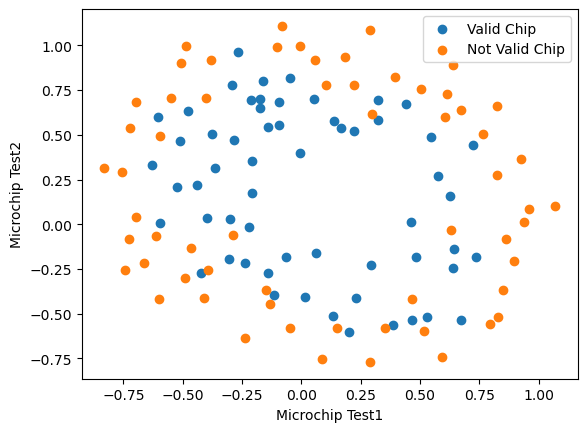

In [18]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Create the 2 scatter plots
valid_chips = plt.scatter(X[mask][0].values, X[mask][1].values)
not_valid_chips = plt.scatter(X[~mask][0].values, X[~mask][1].values)

# #################################################
# FILL IN THE NECESSARY CODE.
# Create the x and y labels for the chart.
plt.xlabel("Microchip Test1")
plt.ylabel("Microchip Test2")

# #################################################
# FILL IN THE NECESSARY CODE.
# Add in a legend (as you have multiple scatterplots, you must provide a
# tupple of data points and a legend text)
# Also draw the plot.

plt.legend((valid_chips, not_valid_chips), ("Valid Chip", "Not Valid Chip"))
plt.show()

This is for sure not a linear problem : So applying 'standard' logistic regression will not help, as 
logistic regression will only define a <b>linear</b> boundary.

We will need to create additional features out of the given features. 

## Feature mapping/Feature engineering
We will implement feature engineering by creating polynomials out of the features x1 and x2 up to the sixth 
power (default value, but overrulable by setting this parameter to a higher or lower degree).

As a result of this mapping, our vector of two features (the scores on two QA tests) has been 
transformed into a 28-dimensional vector (in case of a polynomial of degrees = 6). 

A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to <b>overfitting</b>. 

In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

### Implement feature engineering
We'll use a non-linear boundary to separate the output space. As we have 2 variables, $x_1$ and $x_2$, in our data, we want to combine these into a non-linear function.

We'll built a function of the form (example degree 6):
$1+x_1^0*x_2^0+x_1^0*x_2^1+x_1^0*x_2^2...+x_1^0*x_2^6 + x_1^1*x_2^0+x_1^1*x_2^1+x_1^1*x_2^2...+x_1^1*x_2^5 + x_1^2*x_2^0+x_1^2*x_2^1+x_1^2*x_2^2+x_1^2*x_2^3 ...$ where the addition of the powers of the features $x_1^a$ and $x_2^b$, so the addition of $a$  and $b$, is below a certain number (or degree).

Think in 'variable combination', but use matrix multiplications (np.multiply) and the power function (np.power) of numpy.

- It is not repeated the linear term? 1 + $x_1^0 * x_2^0$

In [19]:
degree = 6             # The degree of the polynomial linear function.
lmbda = 0.001          # The adjustments or jumps made between 2 iterations.
# Try out different values ranging from 0.3, 0.1, 0.03, 0.01, ..., 0.00001.

In [20]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Create the polynomial function
def mapFeature(X1, X2, degree=6):
    test1 = X1.to_numpy()
    test2 = X2.to_numpy()
    # powers
    dimensions = np.arange(degree + 1)
    combinations = it.product(dimensions, dimensions)
    powers = list(filter(lambda combination: combination[0] + combination[1] <= degree, combinations))
    n_rows = len(X1)
    n_cols = len(powers)
    X_new = np.empty((n_rows, n_cols))
    for i in range(len(powers)):
        m = powers[i][0]
        n = powers[i][1]
        X_new[:, i] = np.multiply(np.power(test1, m), np.power(test2, n))
    return X_new

In [21]:
# Define a new varialbe X_eng, that holds our newly generated feature
X_eng = mapFeature(X.iloc[:, 0], X.iloc[:, 1], degree)

## Implementation
Before you start with the actual cost function, recall that the logistic regression hypothesis makes use of the sigmoid function. 

Let's implement the sigmoid function.

### Sigmoid Function

In [22]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Implement the logistic regression function.
# Use numpy functions for the implementation.
def sigmoid(x):
    return 1/(1+np.exp(-x))

### Cost Function
As usual lets code our cost function and gradient functions.

In [23]:
# #################################################
# FILL IN THE NECESSARY CODE
# Implement the logistic regression loss function
# (no need yet to include the regularization term)
def lrCostFunction(theta, X, y, lmbda):
    # as common mathematical convention vectors are passed as columns
    # Output of np.matmul(theta.T, X.T) is a row, y.T is also a row
    # before np.multiply both arrays must have the same shape
    J = (-1/m)*np.sum(np.multiply(y.T, np.log(sigmoid(np.matmul(theta.T, X.T))))
                      + np.multiply((1-y.T), np.log(1 - sigmoid(np.matmul(theta.T, X.T)))))
    return J

There are multiple ways to code cost function. What it is more important is the underlying mathematical ideas and our ability to translate them into code.

## Gradient Function

In [24]:
# #################################################
# FILL IN THE NECESSARY CODE.
# Implement GradientDescent
def lrGradientDescent(theta, X, y, lmbda):
    grad = (1/m) * np.matmul((sigmoid(np.matmul(theta.T, X.T)) - y.T), X)
    return grad

Let's call these functions using the initial parameters.

In [25]:
# Unfortunate notation
# m is the number of datapoints and n is the number of features
m, n = X_eng.shape
X_eng = np.hstack((np.ones((m, 1)), X_eng))
# y = y.to_numpy()  # WRONG! this gives shape (118,)
y = y.to_numpy()[:, np.newaxis]  # this gives shape (118, 1)
# we initialize our learning parameters to zero:
theta = np.zeros((n + 1, 1))
print(X_eng.shape)
print(y.shape)
print(theta.shape)

(118, 29)
(118, 1)
(29, 1)


- From the above results we keep in mind that both y and theta are column vectors

In [26]:
# Call the lrCostFunction with the correct parameters
# (lmbda is not yet needed in the frist go)
J = lrCostFunction(theta, X_eng, y, lmbda)
print(f"Cost value : {J}")

# This gives us a values of 0.69314718 .

Cost value : 0.6931471805599454


In [27]:
pred = [sigmoid(np.dot(X_eng, theta)) >= 0.5]
print("Prediction before optimization : ", np.mean(pred == y.flatten()) * 100, '%')

Prediction before optimization :  49.152542372881356 %


## Learning parameters using fmin_tnc
fmin_tnc is an optimization solver that finds the minimum of an unconstrained function. For logistic 
regression, you want to optimize the cost function with the parameters theta.

In [28]:
output = opt.fmin_tnc(func = lrCostFunction, x0 = theta.flatten(), fprime = lrGradientDescent, \
                         args = (X_eng, y.flatten(), lmbda),messages=0)
theta = output[0]
print('Optimized values :', theta) # theta contains the optimized values

Optimized values : [    6.99800808     6.99800808     8.72121478   -66.61244236
    -9.27745518   110.21472899     2.56597451   -68.42864661
    13.96471687   -79.25991547   -37.32645599   255.3496652
     3.33896176  -234.31627992  -141.36968557  -107.10739912
   589.25429055   155.06650992  -684.73843805  -119.16442252
   463.96639057   329.71918737  -774.93052814   489.69523594
   329.84245291 -1074.31716855   223.25337214  -753.49979345
  -558.91345457]


Note on flatten() function: Unfortunately scipy's fmin_tnc doesn't work well with column or row vector. 
It expects the parameters to be in an array format. The flatten() function reduces a column or row vector 
into array format.

## Accuracy of model
###############################

Lets try to find the model accuracy by predicting the outcomes from our learned parameters and then comparing with the 
original outcomes.

In [29]:
pred = [sigmoid(np.dot(X_eng, theta)) >= 0.5]
print('Model accuracy after optimization and regularization :',np.mean(pred == y.flatten()) * 100, '%')

Model accuracy after optimization and regularization : 88.13559322033898 %


This gives our model accuracy as 85.59% (with degree = 6), with regularization.
This gives our model accuracy as 83.05% (with degree = 6), without regularization.

## Plotting Decision Boundary (optional)

To help you visualize the model learned by this classifier, we will plot the (non-linear) decision boundary that separates 
the positive and negative examples. We plot the non-linear decision boundary by computing the classifier's predictions on 
an evenly spaced grid and then draw a contour plot of where the predictions change from y = 0 to y = 1.

In [59]:
def mapFeatureForPlotting(X1, X2, degree=6):
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j], degree), theta)

ValueError: shapes (28,) and (29,) not aligned: 28 (dim 0) != 29 (dim 0)

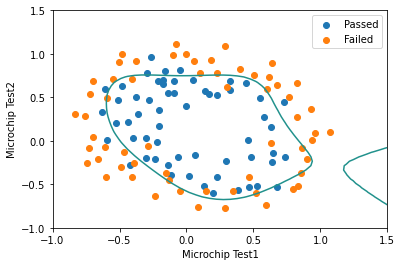

End


In [19]:
mask = y.flatten() == 1
X = data.iloc[:,:-1]
passed = plt.scatter(X[mask][0], X[mask][1])
failed = plt.scatter(X[~mask][0], X[~mask][1])
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()
print("End")

Our model has done pretty good job at classifying the various data points.
Also try changing the values of lmbda to see for yourself how the decision boundary changes.